In [1]:
# import des librairies necessaires 
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Chargement des données

Chargement de la data depuis le fichier csv products local (supposé dans le même dossier)

In [3]:
products = pd.read_csv("products.csv",sep='\t',low_memory=False)

In [4]:
# afficher le nombre de lignes et de colonnes dans le dataset products
print (products.shape)
# visualisation de quelques lignes
initial_len = len(products);
products.head(3)

(320772, 162)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


Il y a au total 320772 produits alimentaires dans l'ensemble de données. Chaque produit alimentaire a 162 variables

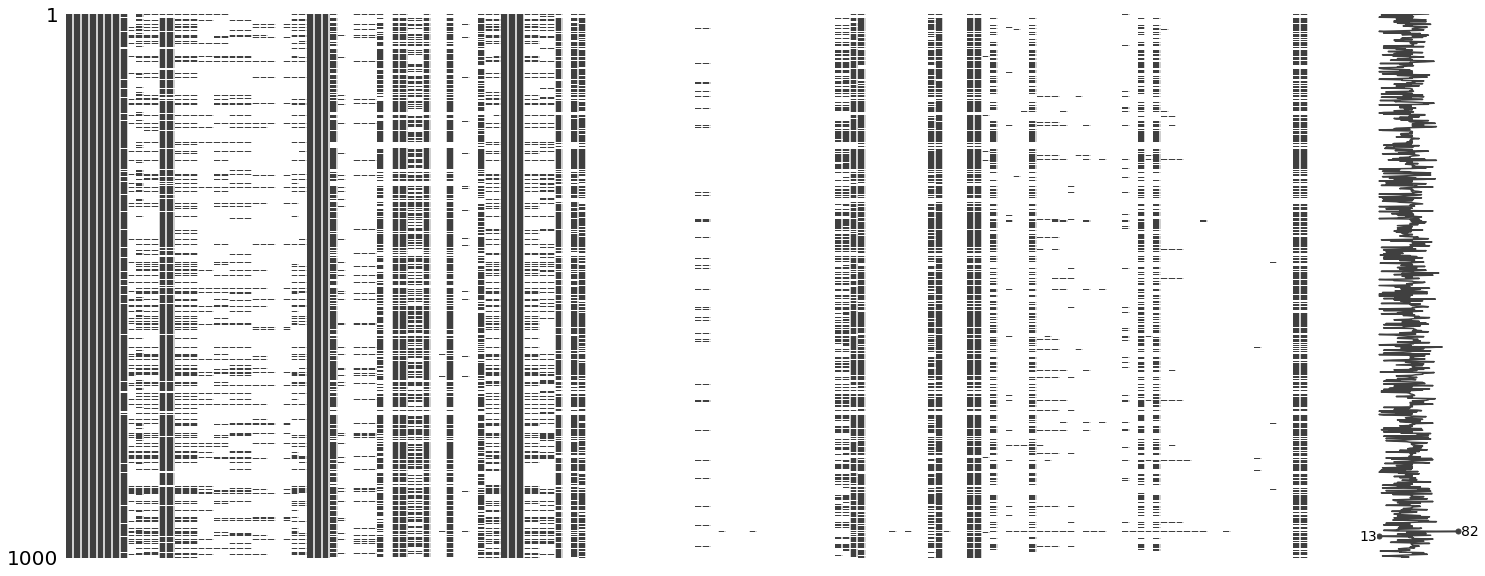

In [5]:
# L’exécution de cette instruction plusieurs fois et avec des « sample » de taille différentes montre bien 
# qu’il y a beaucoup de colonnes presque toujours vide, idem pour les lignes.
msno.matrix(products.sample(1000))

# Gestion des colonnes et des lignes «presque» vides !

Au-delà du caractère «  intéressant ou non » d’une variable, vu le graphique ci-dessus, toutes les variables ne sont pas exploitable, On fait des choix !

In [6]:
# fonction renvoyant le taux de remplissage d'une colonne col au sein d'une dataframe df donnée
def col_filling_rate(df, col):
    return 1 - df[col].isnull().sum() / len(df);

In [7]:
# Un dictionaire (une map) associant chaque colonne avec son taux de remplissage au sein de la df products
rate_by_column = dict((col, col_filling_rate(products, col)) for col in products.columns.values)
# exemple d'item
print('La colonne salt_100g est renseignée avec un taux de :', rate_by_column['salt_100g'])

La colonne salt_100g est renseignée avec un taux de : 0.796547080169


Dans le graphe ci-dessous, on visualise le nombre important de colonnes vides (alimentée à moins de 30%)

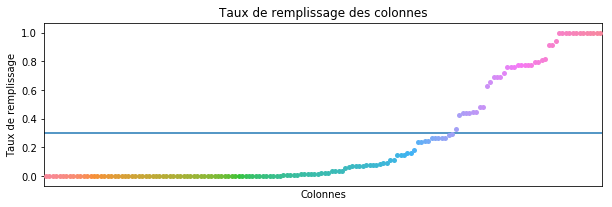

In [8]:
import seaborn as sns
tmp=pd.DataFrame()
tmp['col']=list(rate_by_column.keys())
tmp['fill_ratio']=list(rate_by_column.values())
tmp.sort_values(by='fill_ratio',inplace=True)
plt.figure(figsize=(10,3))
sns.stripplot(x='col', y='fill_ratio', data=tmp)
plt.axhline(y=0.3)
plt.xticks([])
plt.xlabel('Colonnes')
plt.ylabel('Taux de remplissage')
plt.title('Taux de remplissage des colonnes')
plt.show()

Un choix concernant les colonnes: écarter toute variable « presque » vide (à plus de 70%)

In [9]:
# Suppression des colonnes vides à plus de 70% 
for (col, rate) in rate_by_column.items():
    if col in products and rate < 0.3:
        del products[col] 
# nouvelle taille
products.shape

(320772, 43)

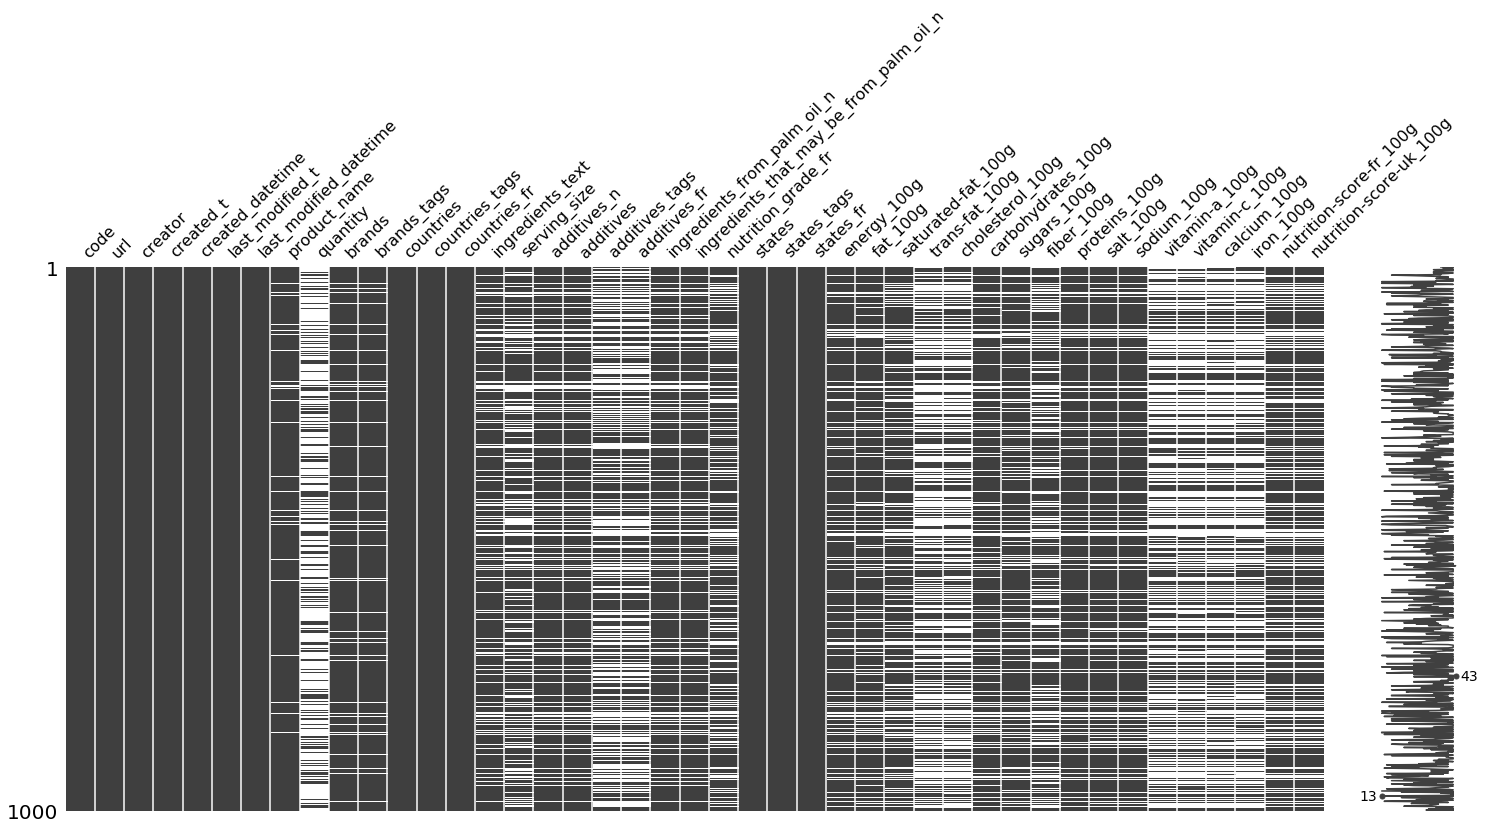

In [10]:
# Re visualisation après avoir supprimé les colonnes "presque" vides.
msno.matrix(products.sample(1000))

Aussi, on remarque ci-dessus que 13 colonnes (parmi les 43 restantes) sont « toujours » renseignées et contiennent des informations « plutôt techniques»(code, url , created_datetimes, countries_fr …),  

Parmi ces 13 colonnes, seule la donnée «countries_fr» est prise en compte plus tard dans cette analyse.  

Par ailleurs, on s'assure que les colonnes potentiellement importantes au vu de l'objectif de notre projet, sont "toujours présentes",  celles indiquant la quntité d'un composant (sucre, sel, vitamine c, fer ...) dans 100g du produit.

In [11]:
# Pour une "row" dans products, cette fonction calcule le taux de remplissage des 30 cellules (parmi les 43)  correspondant
# au colonnes autres que les 13  citées précédemment

def row_filling_rate(row):
    return 1 - sum(row.isnull()) / (43 - 13)

# Ajout d'une nouvelle colonne row_filling_rate
products['row_filling_rate'] = products.apply(lambda row: row_filling_rate(row), axis=1)

Un choix concernant les lignes: écarter toute ligne « presque » vide (à plus de 70%)

In [12]:
# Suppression de l’ensemble des lignes ayant un row_filling_rate < 0.3
products = products[products['row_filling_rate'] >= 0.3]
# nouvelle taille de products
print('Nouvelle taille: ',products.shape, '=> on a supprimé ', 1 - (len(products)/initial_len), '% des lignes')

Nouvelle taille:  (273848, 44) => on a supprimé  0.1462845884304116 % des lignes


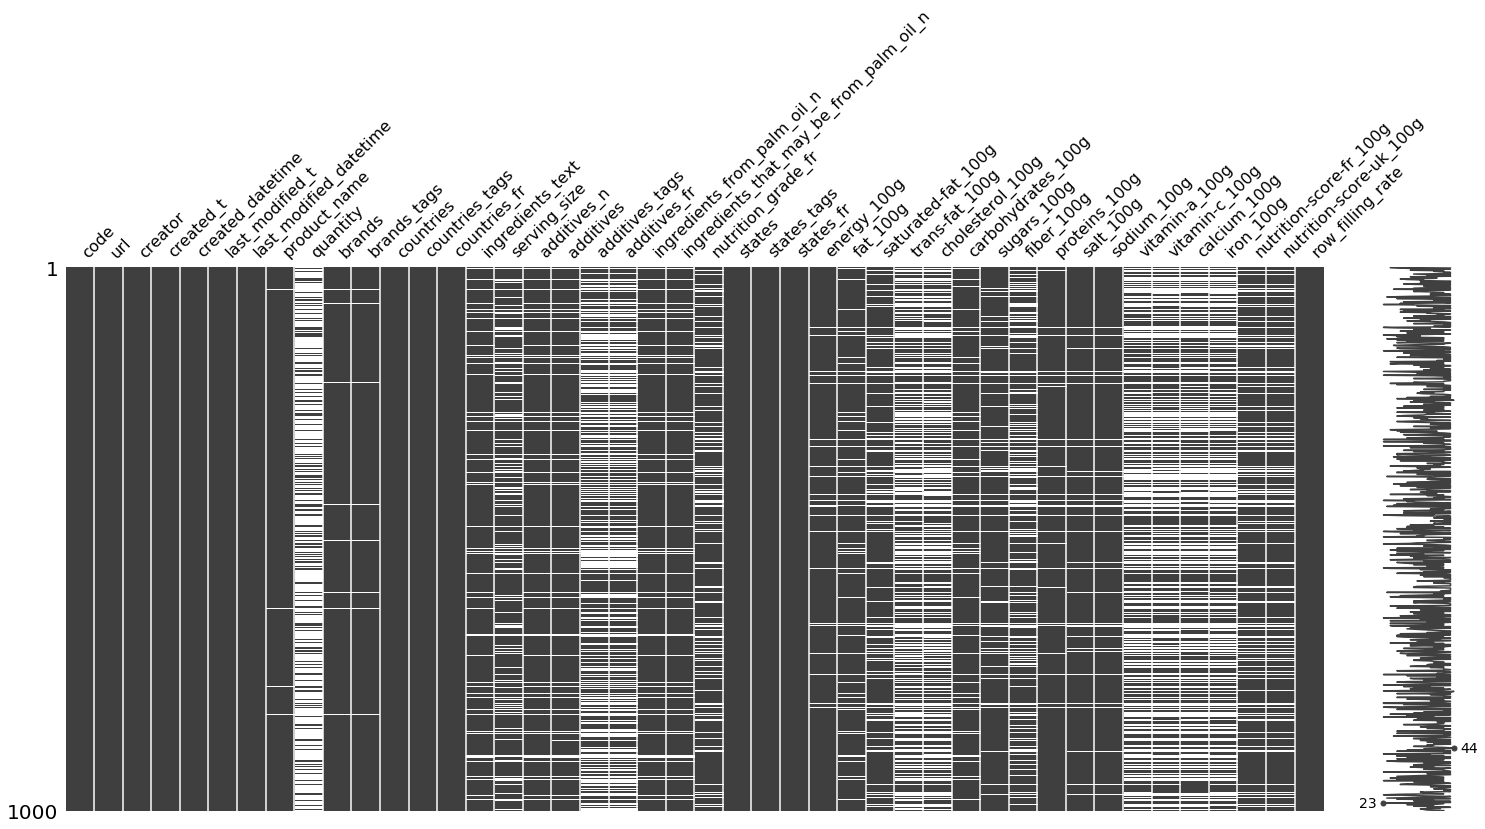

In [13]:
# revisualisation après suppression des lignes, on constate une amélioration (le graphe est plus sombre !)
msno.matrix(products.sample(1000))

# Détection et remplacement des outilers et des manquants

Pour les colonnes  «retenues», je commence une analyse univariée tout en m'intéressant dans un premier temps aux outilers

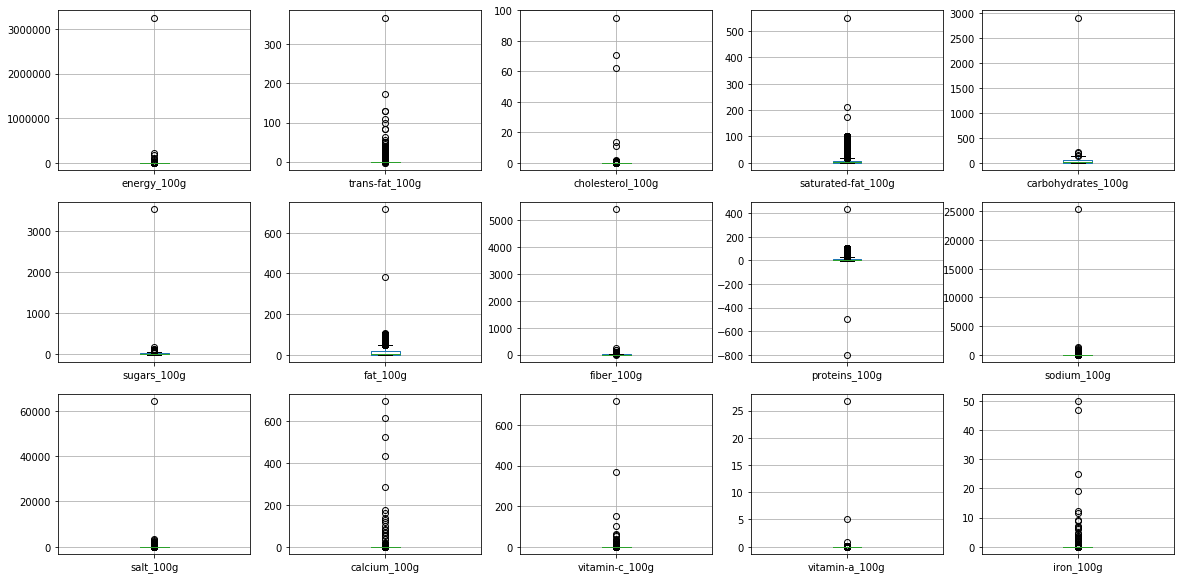

In [14]:
# temps au outliers

plt.figure(figsize=(20, 10))

plt.subplot(3, 5, 1)
products.boxplot(column=['energy_100g'])

plt.subplot(3, 5, 2)
products.boxplot(column=['trans-fat_100g'])

plt.subplot(3, 5, 3)
products.boxplot(column=['cholesterol_100g'])

plt.subplot(3, 5, 4)
products.boxplot(column=['saturated-fat_100g'])

plt.subplot(3, 5, 5)
products.boxplot(column=['carbohydrates_100g'])

plt.subplot(3, 5, 6)
products.boxplot(column=['sugars_100g'])

plt.subplot(3, 5, 7)
products.boxplot(column=['fat_100g'])

plt.subplot(3, 5, 8)
products.boxplot(column=['fiber_100g'])

plt.subplot(3, 5, 9)
products.boxplot(column=['proteins_100g'])

plt.subplot(3, 5, 10)
products.boxplot(column=['sodium_100g'])

plt.subplot(3, 5, 11)
products.boxplot(column=['salt_100g'])

plt.subplot(3, 5, 12)
products.boxplot(column=['calcium_100g'])

plt.subplot(3, 5, 13)
products.boxplot(column=['vitamin-c_100g'])

plt.subplot(3, 5, 14)
products.boxplot(column=['vitamin-a_100g'])

plt.subplot(3, 5, 15)
products.boxplot(column=['iron_100g'])

plt.show()

Pour toutes les variables, on remarque des valeurs «vraisemblablement aberrantes» car très 
éloignées de l’intervalle interquartile.  

Les deux extrémités d’une boxplot, sont la plus grande valeur (resp petite valeur) inférieure (resp. supérieure) à  q3 + 1.5(q3 - q1)  (resp. q1 - 1.5(q3 - q1) ),  
où q1, q3 sont respectivement les quantiles à 0.25 et 0.75.  

Un choix : toute valeur en dehors de ces limites est remplacée par la médiane (étant robuste dans le sens insensible aux valeurs extrêmes) 


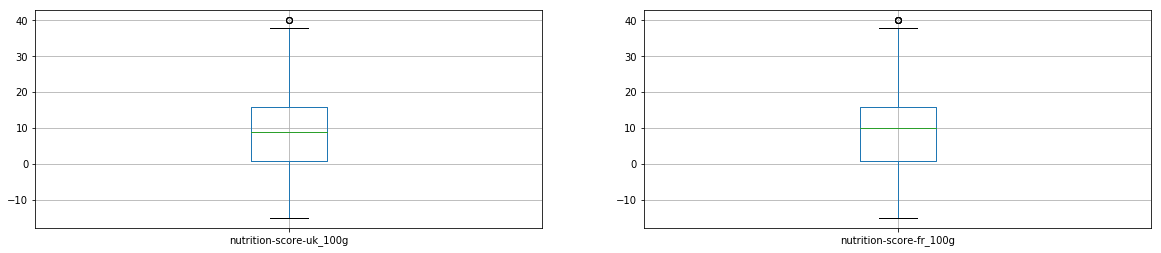

In [15]:
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
products.boxplot(column=['nutrition-score-uk_100g'])

plt.subplot(1,2,2)
products.boxplot(column=['nutrition-score-fr_100g'])
plt.show()

On constate par ailleurs que la distribution (outilers compris) des variables score_uk et score_fr n'est pas sensiblement différente

In [16]:
# fonctions renvoyant les 3 quartiles pour une colonne donnée.
def q1(col):
    return products[col].quantile(.25) # premier quartile
def median(col):
    return products[col].quantile(.5)  # deuxième quartile
def q3(col):
    return products[col].quantile(.75) # troisième quartile

In [17]:
def l_inf(col):
    return q1(col) - 1.5 * (q3(col) - q1(col))


def l_sup(col):
    return q3(col) + 1.5 * (q3(col) - q1(col))

In [18]:
# Fonction servant à remplacer les valeur manquantes
def fill_na(df, col, new_value):
    if callable(new_value):
        new_value = new_value(df, col)   # l'idée est de pouvoir passer soit une valeur directe ou bien
    df[col] = df[col].fillna(new_value)  # une lambda renvoyant une valeur de remplacement

In [19]:
# Cette fonction remplace les outliers par la valeur new_value (ou la valeur renvoyée par new_value s’il s’agit d’une fonction)
def replace_outliers(df, col, predicate, new_value):
    if callable(new_value):
        new_value = new_value(df, col)                             
    df.loc[predicate(df[col]), col] = new_value


Aussi, dans la fonction de nettoyage ci-après, on remplace les valeurs manquantes par la médiane également. 


In [20]:
# Fonction de nettoyage de données
# considérer comme "outlier" toute valeur o tel que o > q3 + 1.5(q3 - q1) ou o < q1 - 1.5(q3 - q1)
# remplacer les outliers par la médiane étant plus robuste est moins sensible au valeurs extrêmes.
# remplacer les manquants par la médiane
def clean(df, col):
    inf = l_inf(col)
    sup = l_sup(col)
    me = median(col)
    fill_na(df, col, me)
    replace_outliers(df, col, lambda x: (x < inf) | (x > sup), me)

In [21]:
# nettoyage
for col in ['energy_100g','trans-fat_100g', 'cholesterol_100g','saturated-fat_100g','carbohydrates_100g', 
            'sugars_100g','fat_100g','fiber_100g','proteins_100g','sodium_100g',
            'salt_100g','calcium_100g','vitamin-c_100g','vitamin-a_100g','iron_100g',
            'nutrition-score-fr_100g','nutrition-score-uk_100g']:
    clean(products, col)

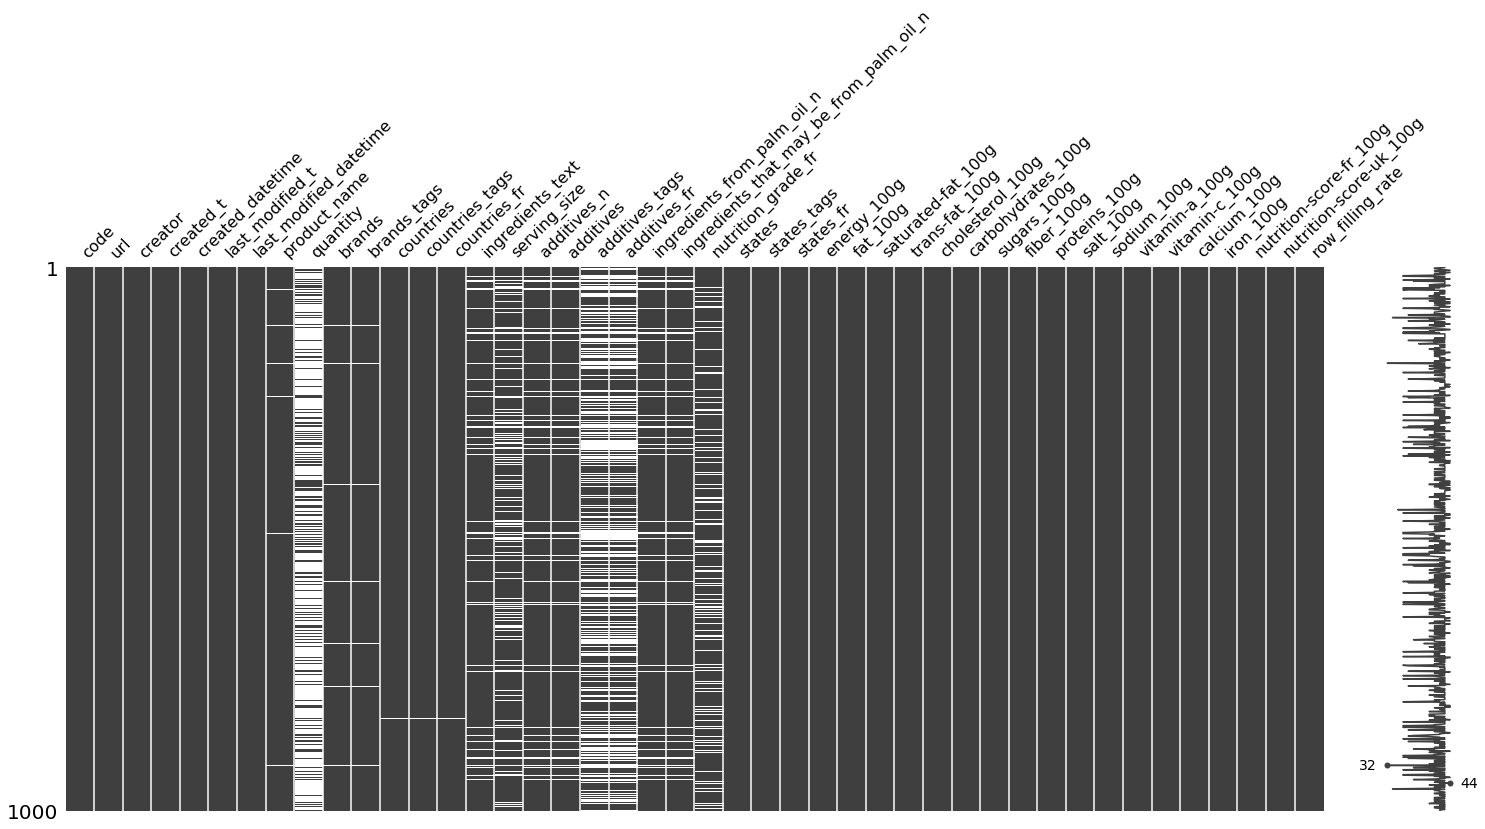

In [22]:
# revisualisation globale après nettoyage.
msno.matrix(products.sample(1000))

Visiblement, le dataset est désormais plus « exploitable »

# Analyse univarié

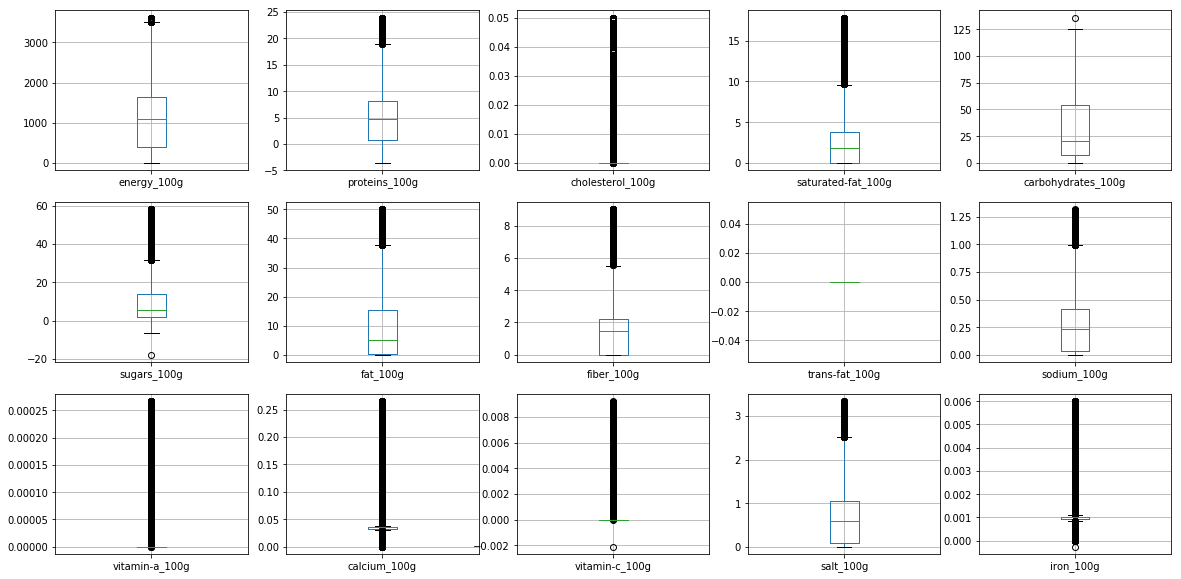

In [22]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 5, 1)
products.boxplot(column=['energy_100g'])

plt.subplot(3, 5, 2)
products.boxplot(column=['proteins_100g'])

plt.subplot(3, 5, 3)
products.boxplot(column=['cholesterol_100g'])

plt.subplot(3, 5, 4)
products.boxplot(column=['saturated-fat_100g'])

plt.subplot(3, 5, 5)
products.boxplot(column=['carbohydrates_100g'])

plt.subplot(3, 5, 6)
products.boxplot(column=['sugars_100g'])

plt.subplot(3, 5, 7)
products.boxplot(column=['fat_100g'])

plt.subplot(3, 5, 8)
products.boxplot(column=['fiber_100g'])

plt.subplot(3, 5, 9)
products.boxplot(column=['trans-fat_100g'])

plt.subplot(3, 5, 10)
products.boxplot(column=['sodium_100g'])

plt.subplot(3, 5, 11)
products.boxplot(column=['vitamin-a_100g'])

plt.subplot(3, 5, 12)
products.boxplot(column=['calcium_100g'])

plt.subplot(3, 5, 13)
products.boxplot(column=['vitamin-c_100g'])

plt.subplot(3, 5, 14)
products.boxplot(column=['salt_100g'])

plt.subplot(3, 5, 15)
products.boxplot(column=['iron_100g'])

plt.show()

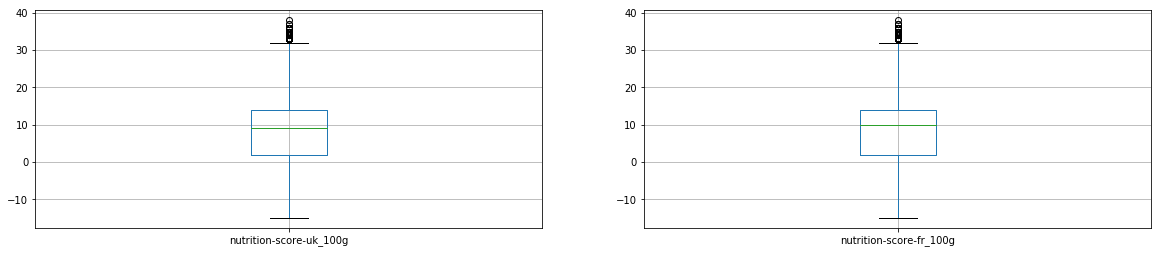

In [23]:
plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
products.boxplot(column=['nutrition-score-uk_100g'])

plt.subplot(1,2,2)
products.boxplot(column=['nutrition-score-fr_100g'])
plt.show()

Quelques remarques par rapport aux histogrammes ci-dessous:  
Visiblement « beaucoup » de produits sont riches en sucre, l’histogramme ne commence à descendre significativement qu’à partir de 20g  
La quantité de la graisse et la graisse saturée pour environ 20000 produits reste considérable entre 10g et 20g.  
La quantité des carbohydrates est relativement « grande », elle est « petite »  pour environ 10000 produits, mais il y a aussi un léger pic autour de la valeur 60g !!?  
Pour les fibres, au-delà de 2g, peu de produits en contiennent.  
Peu de produits contiennent « beaucoup de sel »  > 3g, je suppose qu’il s’agit des produits salés (chips, ..)

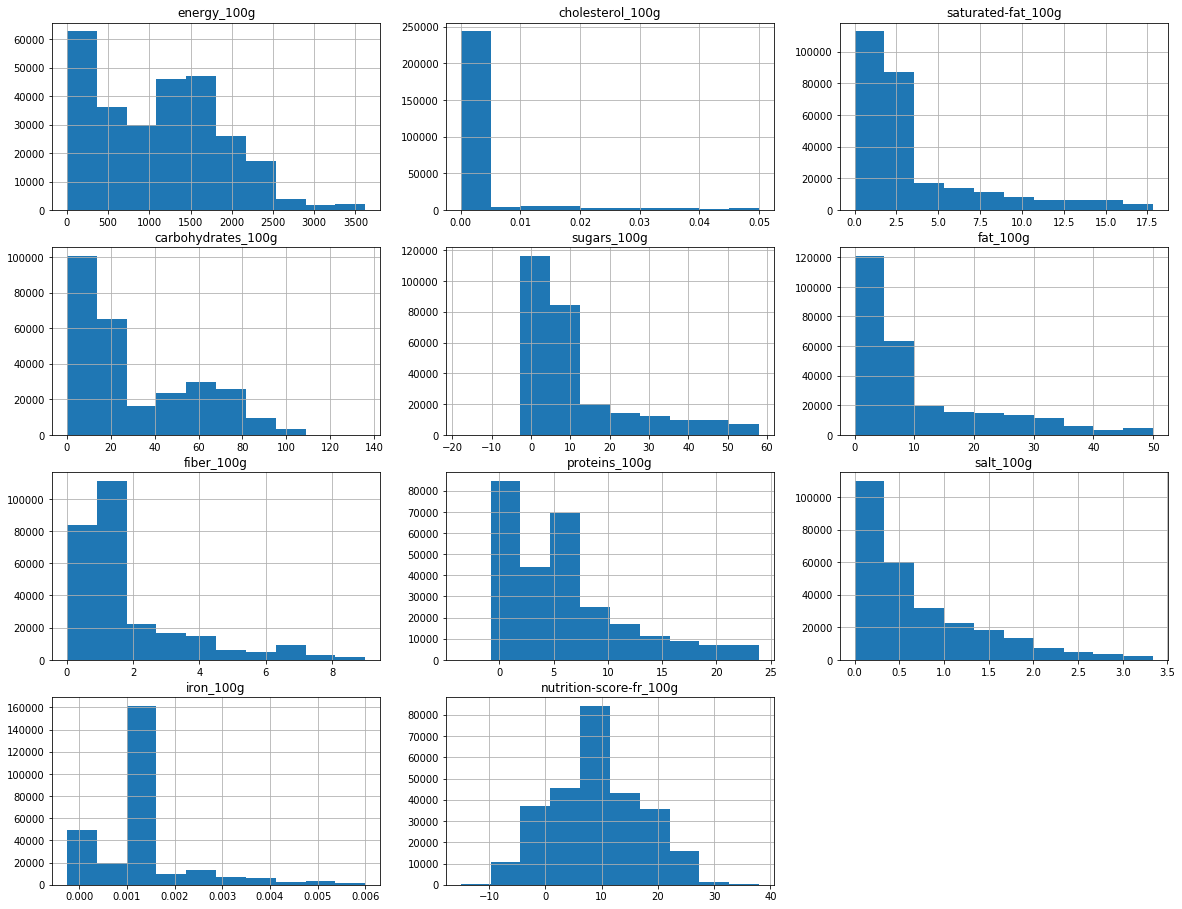

In [45]:
plt.figure(figsize=(20, 20))
i = 1
for col in ['energy_100g', 'cholesterol_100g','saturated-fat_100g','carbohydrates_100g', 
            'sugars_100g','fat_100g','fiber_100g','proteins_100g','salt_100g','iron_100g',
            'nutrition-score-fr_100g']:
    ax1 = plt.subplot(5, 3, i)
    products[col].hist()
    ax1.title.set_text(col)
    i = i + 1

plt.show()

# Analyse bivariée

In [24]:
# affichage de la matrice de correlation entre les différentes colonnes
products.corr()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,...,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,row_filling_rate
additives_n,1.000000,0.119574,0.285524,0.000470,-0.038878,0.055659,NaN,0.105626,0.162449,0.138371,...,-0.066204,0.078140,0.078763,0.012848,-0.034096,0.042074,-0.008233,0.148638,0.146526,0.161721
ingredients_from_palm_oil_n,0.119574,1.000000,0.186781,0.101115,0.087471,0.125307,NaN,-0.044901,0.075295,0.100097,...,0.011907,-0.007675,-0.007712,-0.049295,-0.038208,-0.016487,-0.012195,0.108764,0.112399,-0.054714
ingredients_that_may_be_from_palm_oil_n,0.285524,0.186781,1.000000,0.023280,0.025427,0.075224,NaN,0.002715,0.015925,0.036865,...,-0.019891,0.028328,0.028148,-0.011277,-0.038156,-0.007337,-0.037960,0.052058,0.053519,-0.040016
energy_100g,0.000470,0.101115,0.023280,1.000000,0.606142,0.476518,NaN,0.012168,0.500364,0.309369,...,0.293114,0.115814,0.115500,-0.085632,-0.121729,0.065348,0.290446,0.557258,0.581465,0.102415
fat_100g,-0.038878,0.087471,0.025427,0.606142,1.000000,0.533491,NaN,0.100539,0.064654,0.191116,...,0.329534,0.247321,0.247278,0.046693,-0.054198,0.116643,0.166379,0.538889,0.562579,0.210777
saturated-fat_100g,0.055659,0.125307,0.075224,0.476518,0.533491,1.000000,NaN,0.149443,0.023909,0.208108,...,0.186789,0.128302,0.128710,0.097974,-0.076877,0.102845,0.072481,0.580822,0.600803,0.072152
trans-fat_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cholesterol_100g,0.105626,-0.044901,0.002715,0.012168,0.100539,0.149443,NaN,1.000000,-0.027813,0.084789,...,0.092692,0.085365,0.085749,0.235985,0.080225,0.207807,-0.047930,0.086684,0.095051,0.261688
carbohydrates_100g,0.162449,0.075295,0.015925,0.500364,0.064654,0.023909,NaN,-0.027813,1.000000,0.438656,...,0.011593,-0.088187,-0.088557,-0.094018,-0.068296,0.001454,0.262790,0.218718,0.223472,0.193979
sugars_100g,0.138371,0.100097,0.036865,0.309369,0.191116,0.208108,NaN,0.084789,0.438656,1.000000,...,-0.123248,-0.177636,-0.177805,0.005955,-0.039210,0.056106,0.069783,0.438492,0.433506,0.123257


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['median', 'rate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\ProgramData\Anaconda3\lib\site-packages\biokit\viz\linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


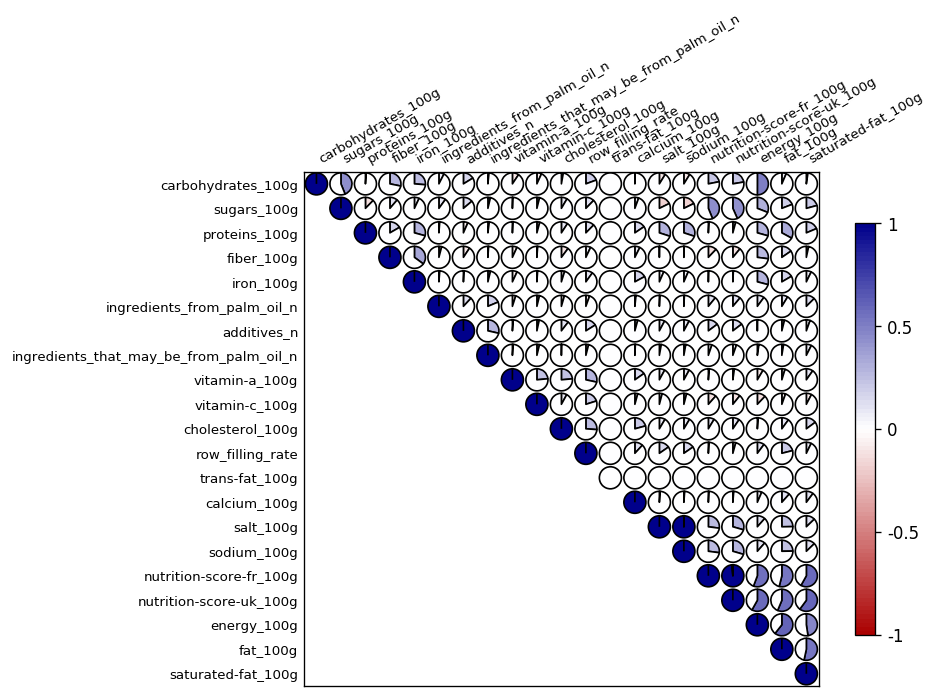

In [25]:
%pylab inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (8,6)
from biokit.viz import corrplot
c = corrplot.Corrplot(products.corr())
c.plot(method='pie', upper='pie', shrink= .9, grid=False, fontsize=8)
plt.show()

Certaine variables sont visiblement corrélées linéairement , je les reprend dans le graphe ci-dessous

C:\ProgramData\Anaconda3\lib\site-packages\biokit\viz\linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


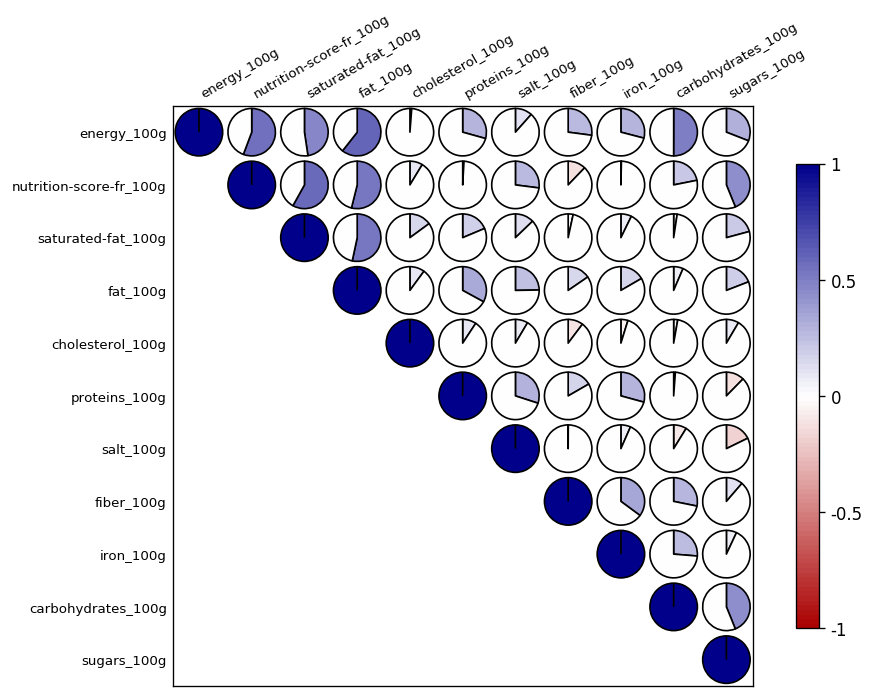

In [26]:
tmp=pd.DataFrame()
for col in ['energy_100g', 'cholesterol_100g','saturated-fat_100g','carbohydrates_100g', 
            'sugars_100g','fat_100g','fiber_100g','proteins_100g','salt_100g','iron_100g',
            'nutrition-score-fr_100g']:
    tmp[col]=products[col]
c = corrplot.Corrplot(tmp.corr())
c.plot(method='pie', upper='pie', shrink= .9, grid=False, fontsize=8)
plt.show()

In [27]:
import seaborn as sns
def reg(df, col_x, col_y, sample_size, psize = 3):
    g = sns.lmplot(x=col_x, y=col_y, truncate=True,size=psize, data=products.sample(sample_size))
    g.set_axis_labels(col_x, col_y)
    plt.xticks(rotation=30)
    plt.title('Régression '+ col_y + "/"+col_x)

Sans surprise, une forte corrélation linéaire entre le sel et le sodium

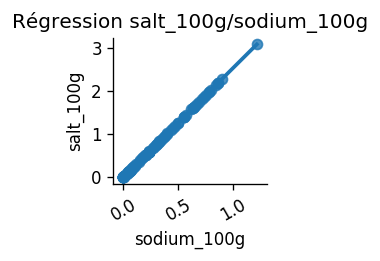

In [28]:
reg(products, "sodium_100g", "salt_100g", 100, 2)

Malgré qu’il n’y pas de forte corrélation linéaire  entre le sel et le score , on constate tout de
même ci-dessous qu'une augmentation du sel est accompagnée d'une tendance d'augmentation du score.

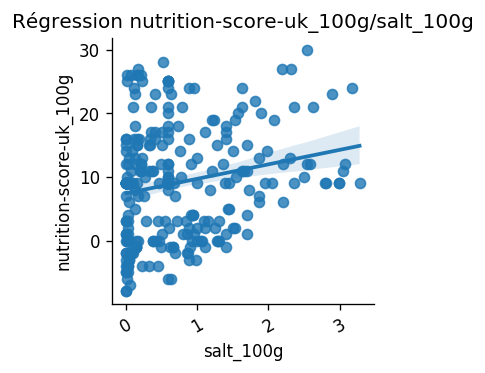

In [29]:
reg(products, "salt_100g", "nutrition-score-uk_100g", 300, 3)

Le graphe ci-après confirme clairement la corrélation linéaire forte entre la graisses saturées et le score

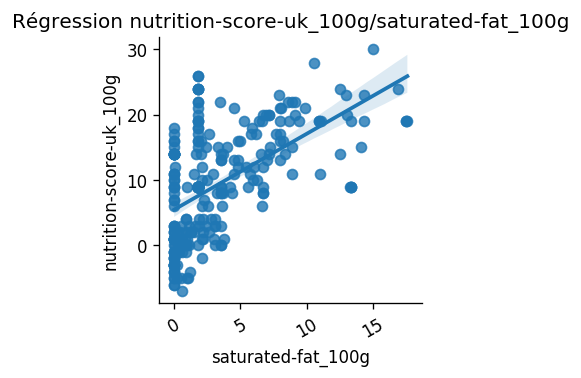

In [30]:
reg(products, "saturated-fat_100g", "nutrition-score-uk_100g", 300, 3)

Idem, le graphe ci-après confirme clairement la corrélation linéaire forte entre la graisse et le score

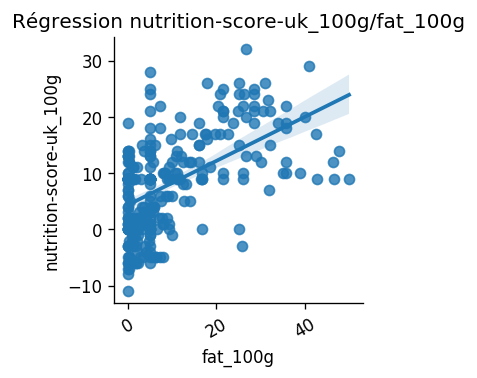

In [31]:
reg(products, "fat_100g", "nutrition-score-uk_100g", 300, 3)

Corrélation linéaire aussi (moins forte !)

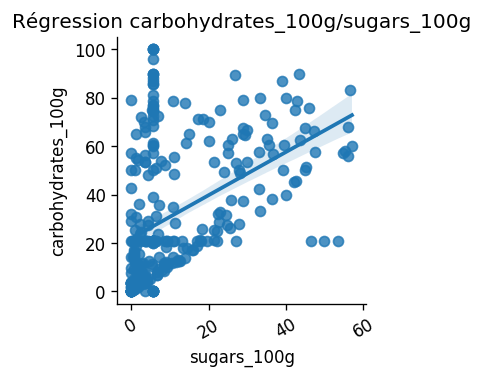

In [32]:
reg(products, "sugars_100g", "carbohydrates_100g", 300, 3)

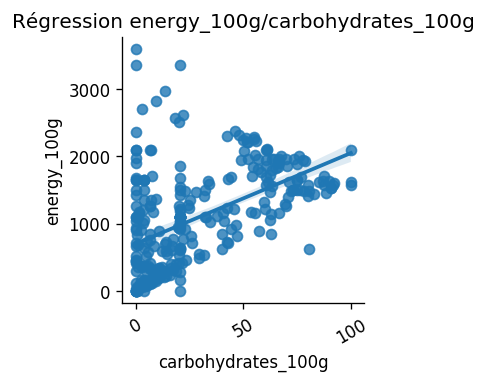

In [33]:
reg(products, "carbohydrates_100g", "energy_100g", 300, 3)

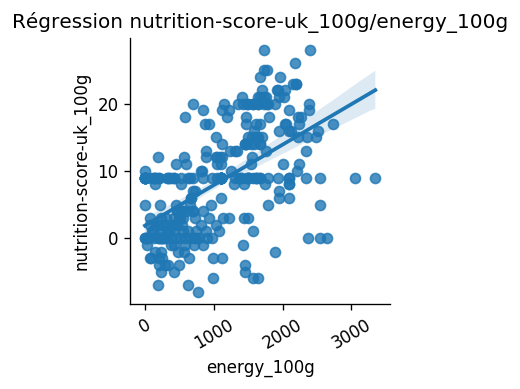

In [34]:
reg(products, "energy_100g", "nutrition-score-uk_100g", 300, 3)

Malgré qu’il n’y pas de forte corrélation linéaire  entre le fibre et le score,  on constate tout de même qu'une augmentation du fibre est acompagnée d'une diminution du score.

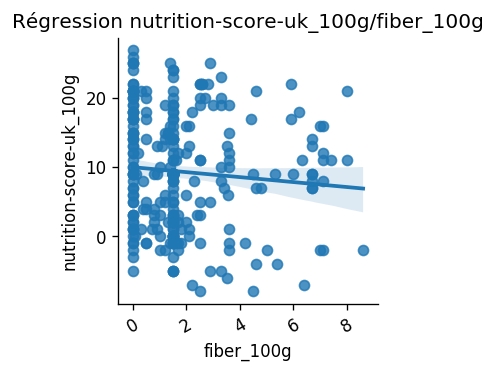

In [35]:
reg(products, "fiber_100g", "nutrition-score-uk_100g", 300, 3)

Peut on "timidement" affirmer qu'une augmentation du protéine est associée à une diminution du score ?

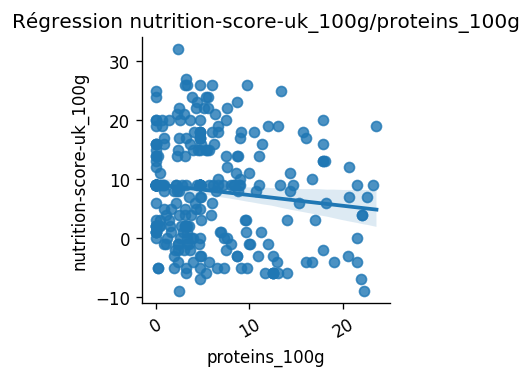

In [36]:
reg(products, "proteins_100g", "nutrition-score-uk_100g", 300, 3)

Récapitulatif

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


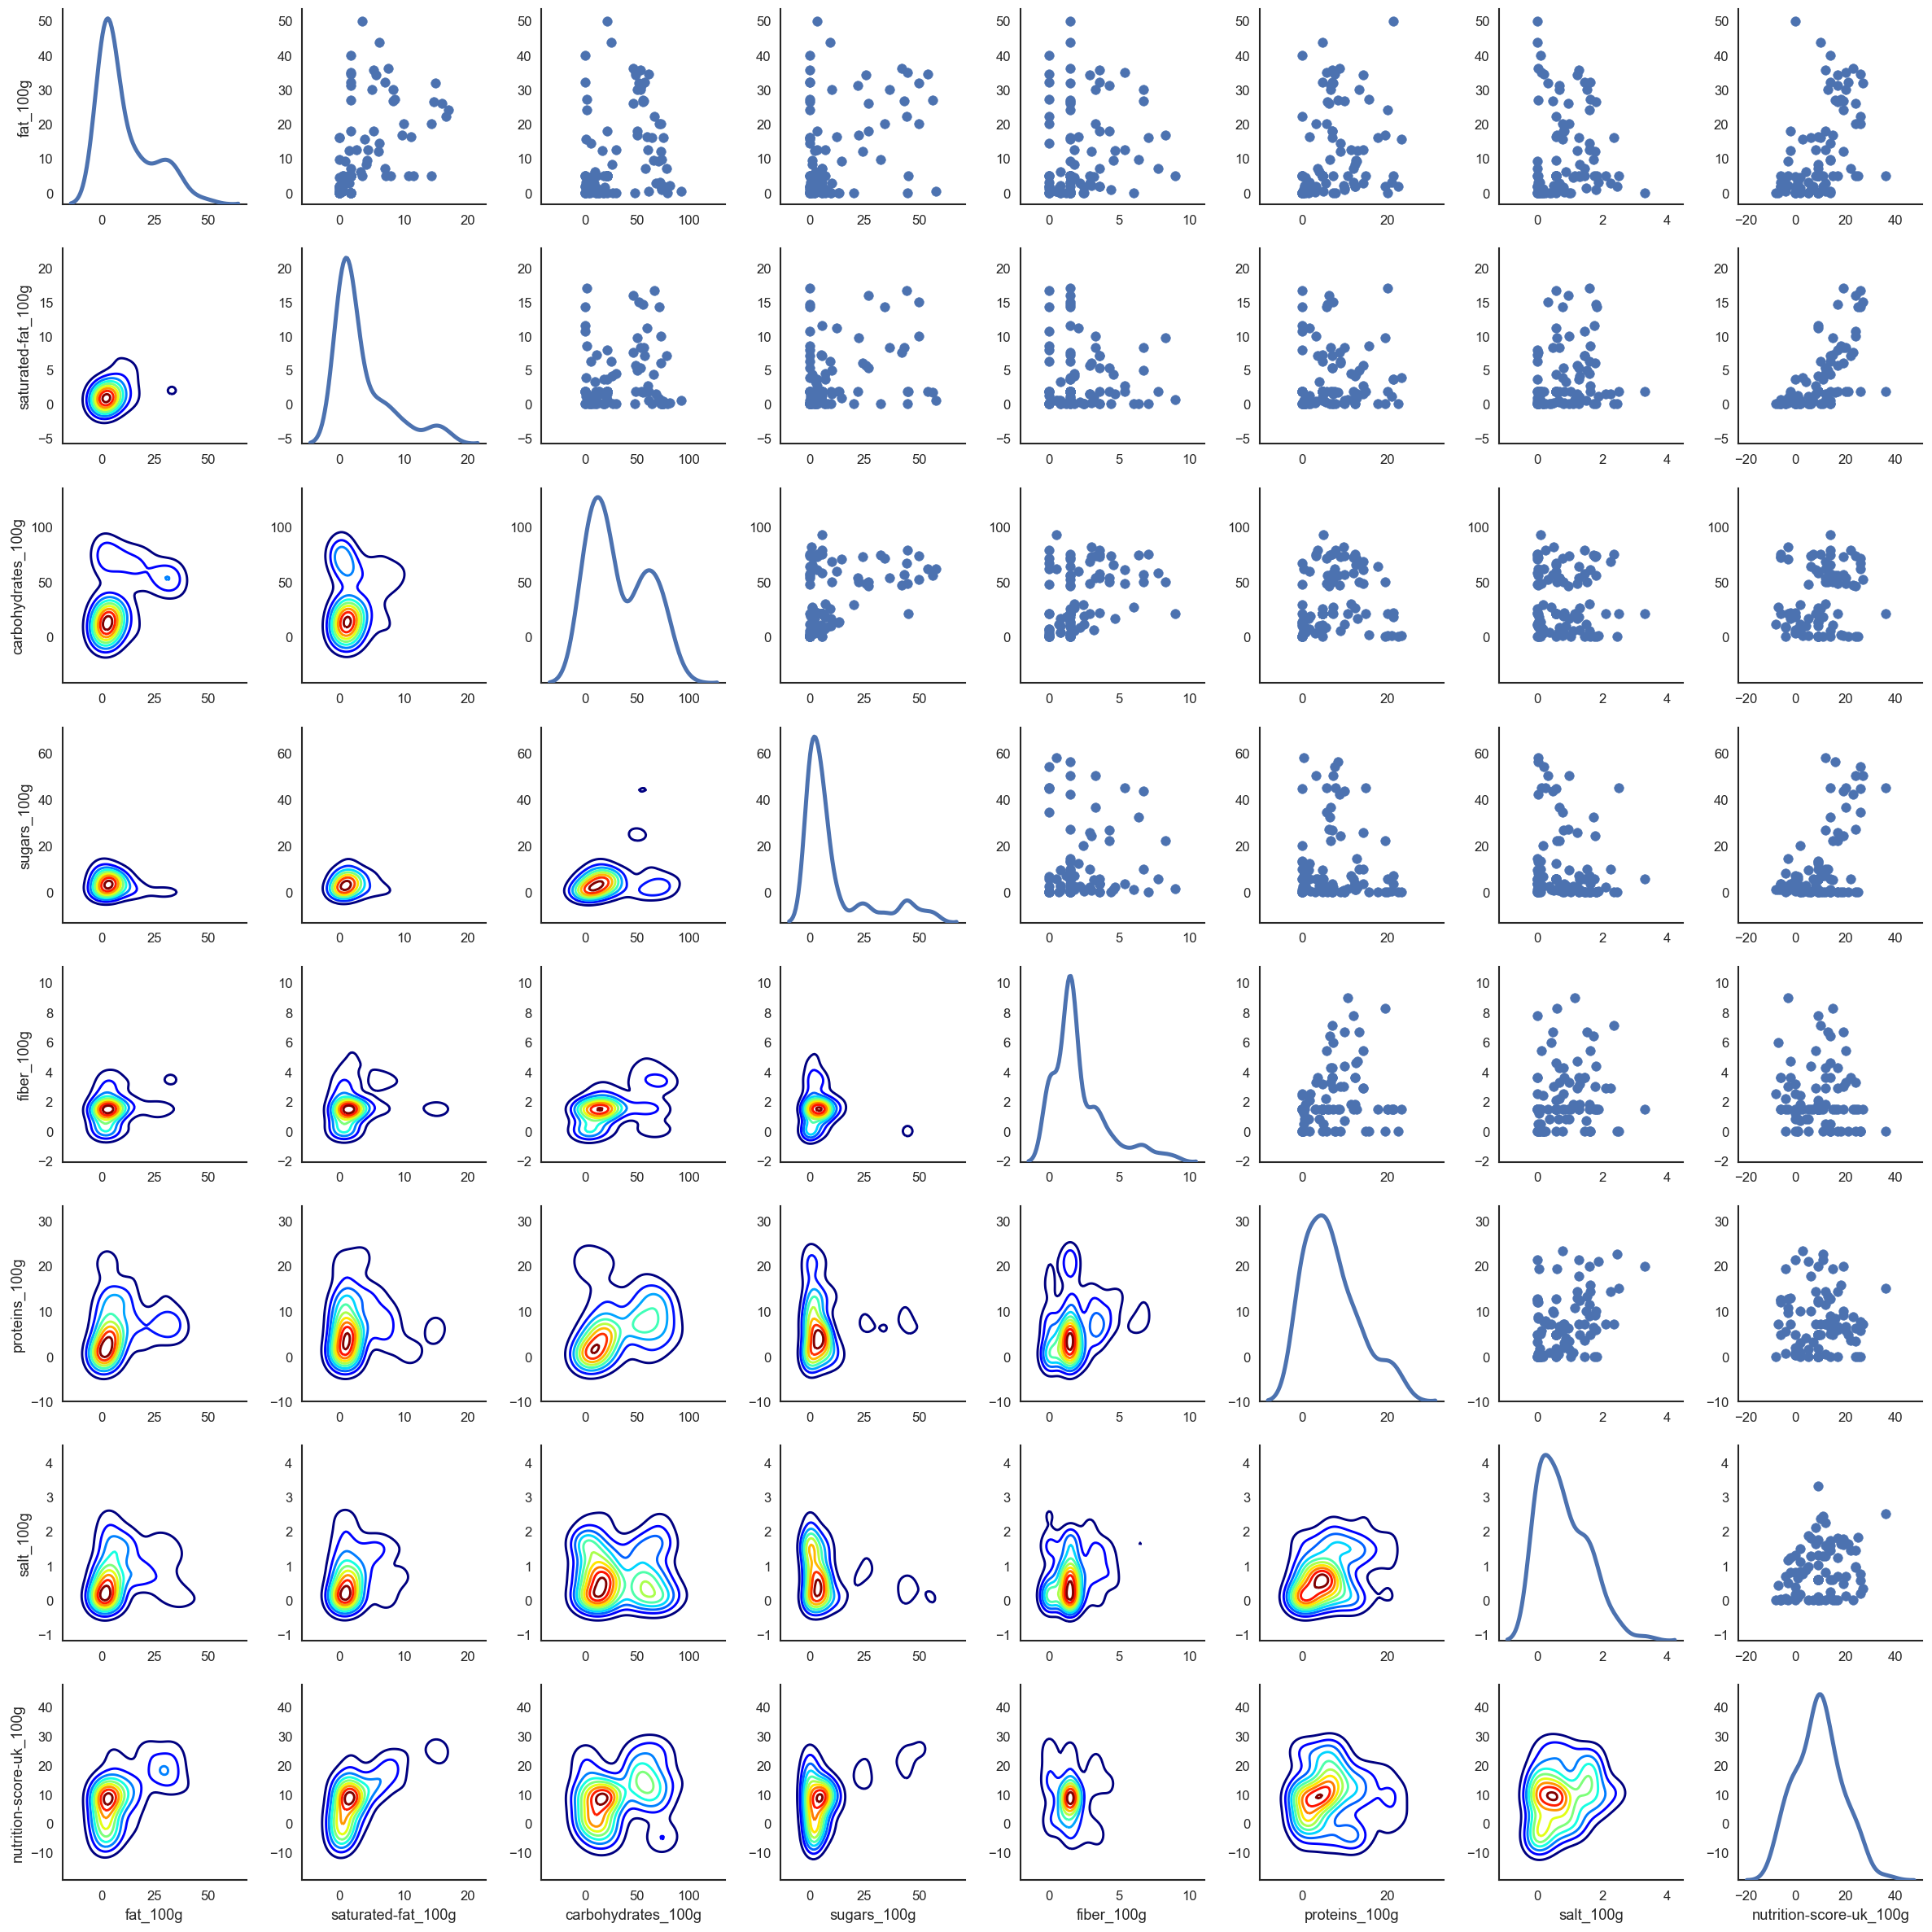

In [37]:
sns.set(style="white")
products_small = products.drop(
    [col for col in products.columns.values 
     if col not in ['nutrition-score-uk_100g','carbohydrates_100g','sugars_100g','salt_100g', 'proteins_100g', 
                    'fiber_100g','fat_100g', 'saturated-fat_100g']
    ], axis=1, inplace=False
)
g = sns.PairGrid(products_small.sample(100), diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="jet")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

# Exploitation de la donnée Pays

Grace à la visualisation des entrées uniques ci-après, on constate 3 choses :
   - la donnée n'est pas propre (exemples :  'États-Unis,en:Pays-bas', 'Suisse,xx:Danemark')
   - la donnée n'est pas toujours en Français (exemples :'en:سلطنة-عمان','ประเทศไทย'  )
   - Plusieurs pays peuvent concerner le meme produit (row)

In [38]:
# --- Exploitation de la donnée "countries_fr" --- #

# Grace à la visualisation des entrées uniques ci-après, on constate 3 choses :
#   - la donnée n'est pas propre (exemples :  'États-Unis,en:Pays-bas', 'Suisse,xx:Danemark')
#   - la donnée n'est pas toujours en Français (exemples :'en:سلطنة-عمان','ประเทศไทย'  )
#   - Plusieurs pays peuvent concerner le meme produit (row)

print(products.countries_fr.unique()[0:50])

['États-Unis' 'Royaume-Uni' 'France,États-Unis' 'Canada' 'France'
 'Allemagne' 'Espagne' 'Australie' 'France,Royaume-Uni'
 'Belgique,France,Pays-Bas,Royaume-Uni' 'Canada,États-Unis'
 'Canada,France,Suisse,États-Unis' 'France,États-Unis,en:Etats-unis'
 'Irlande' 'Royaume-Uni,États-Unis' 'Belgique,France'
 'États-Unis,en:Australie' 'Arabie saoudite' 'Australie,États-Unis'
 'France,Suisse'
 'Australie,Nouvelle-Zélande,Singapour,Thaïlande,États-Unis'
 'États-Unis,en:Pays-bas' 'Pays-Bas' 'Espagne,Royaume-Uni,en:Scotland'
 'Polynésie française,États-Unis' nan 'Mexique' 'Suisse,États-Unis'
 'Allemagne,États-Unis' 'États-Unis,en:Deutschland' 'Suisse'
 'France,Suisse,États-Unis' 'Belgique,Suisse,États-Unis'
 'Danemark,États-Unis,en:Spanien' 'États-Unis,en:Belgie,en:Nederland'
 'Belgique,Suisse' 'France,Allemagne' 'Malaisie,États-Unis'
 'Guyana,États-Unis' 'Serbie' 'Hong Kong' 'Bahreïn,États-Unis'
 'France,Italie' 'Taiwan,États-Unis' 'États-Unis,en:Niederlande' 'Cuba'
 'France,Royaume-Uni,États-

Dans un premier temps, on remarque qu'en "splitant" une entrée dans la colonne "countries_fr" et grace à une
expression régulière simple on peut avoir par produit une liste contenant les diffrents pays associés (dans un état brut).

In [39]:
# Dans un premier temps, on remarque qu'en "splitant" une entrée dans la colonne "countries_fr" et grace à une
# expression régulière simple on peut avoir par produit une liste contenant les diffrents pays associés (dans un etat brut).

import re
# exemple
[(re.sub(".+:", "", country)) for country in 'États-Unis,en:Pays-bas, en:العراق'.upper().split(',')]

['ÉTATS-UNIS', 'PAYS-BAS', 'العراق']

Certains noms désignent le même pays en différentes langues, j’ai recensé les cas possibles et construis un dictionnaire de traduction.

In [40]:
# On recense tous les résultats possibles, et on utilise un dictionnaire pour traduire les noms des pays
import re
_fr = dict({
    "FRANCIAORSZAG":"FRANCE",
    "FRANKRIKE":"FRANCE",
    "FRANKREICH":"FRANCE",
    "BOUCHES-DU-RHONE":"FRANCE",
    "BOURGOGNE-AUBE-NOGENT-SUR-SEINE":"FRANCE",
    "AIX-EN-PROVENCE": "FRANCE",
    "FRANKRIJK":"FRANCE",
    "MARSEILLE-6":"FRANCE",
    "السعودية": "ARABIE SAOUDITE",
    "الإمارات-العربية-المتحدة": "ÉMIRATS ARABES UNIS",
    "AUSTRALIEN":"AUSTRALIE",
    "AZƏRBAYCAN":"AZERBAÏDJAN",
    "BELGIE":"BELGIQUE",
    "BELGIEN":"BELGIQUE",
    "DENEMARKEN":"DANEMARK",
    "DEUTSCHLAND":"ALLEMAGNE",
    "DUITSLAND":"ALLEMAGNE",
    "FINAND":"FINLANDE",
    "GUYANA":"GUYANE",
    "ISLAND":"ISLANDE",
    "ITALIAANS":"ITALIE",
    "ITALIEN":"ITALIE",
    "KINA":"KENYA",
    "SCHWEIZ":"SUISSE",
    "SVAJC":"SUISSE",
    "MAGYARORSZAG": "HONGRIE",
    "NEDERLAND":"PAYS-BAS",
    "HOLLANDE":"PAYS-BAS",
    "NOORWEGEN":"NORVEGE",
    "OTHER-JAPON":"JAPON",
    "OTHER-TURQUIE":"TURQUIE",
    "OTHER-日本":"JAPON",
    "PORTUGALIA":"PORTUGAL",
    "REPUBLIK-CHINA":"CHINE",
    "REPUBLIQUE-DE-CHINE":"CHINE",
    "SPANIEN":"ESPAGNE",
    "SPANJE":"ESPAGNE",
    "SPANYOLORSZAG":"ESPAGNE",
    "SVERIGE":"SUÈDE",
    "ZWITSERLAND":"SUÈDE",
    "ZWEDEN":"SUÈDE",
    "SZCZECIN":"POLOGNE",
    "TURKIYE":"TURQUIE",
    "CZECH":"RÉPUBLIQUE TCHÈQUE",
    "TSCHECHIEN":"RÉPUBLIQUE TCHÈQUE",
    "VEREINIGTES-KONIGREICH":"ROYAUME-UNI",
    "ANGLETERRE":"ROYAUME-UNI",
    "العراق":"IRAK",
    "المملكة-المتحدة":"ROYAUME-UNI",
    "سلطنة-عمان":"OMAN",
    "ประเทศออสเตรเลีย":"AUSTRALIE",
    "สหราชอาณาจักร":"ROYAUME-UNI",
    "ประเทศไทย":"THAÏLANDE",
    "THAILAND":"THAÏLANDE",
    "日本":"JAPON",
    "香港":"HONG KONG",
    "КАЗАХСТАН":"KAZAKHSTAN",
    "SCOTLAND":"ÉCOSSE",
    "ETATS-UNIS":"ÉTATS-UNIS",
    "NAN":"INCONNU"
})

# fonction de traduction
def synonym(x):
    return _fr[x] if x in _fr else x

In [41]:
# Fonction servant à nettoyer une valeur lue dans la colonne countries_fr (la fonction utilise un cache interne pour
# ne faire le traitement qu'une seule fois pour des inputs égaux)
def clean_country(entry):
    if entry in clean_country.cache: # memoization du résultat 
        return clean_country.cache[entry]
    result = [synonym(re.sub(".+:", "", country)) for country in str(entry).upper().split(',')]
    clean_country.cache[entry] = result
    return result
clean_country.cache = {}

In [42]:
# exemples 
print(clean_country('Suisse,Frankrijk,Nederland'))
print(clean_country('en:Gulf-countries,ประเทศออสเตรเลีย'))
print(clean_country('Danemark,en:France,Italie,Pays-Bas,Pologne,Portugal,Espagne'))
print(clean_country('en:香港'))
print(clean_country('France,en:العراق,en:المملكة-المتحدة'))

['SUISSE', 'FRANCE', 'PAYS-BAS']
['GULF-COUNTRIES', 'AUSTRALIE']
['DANEMARK', 'FRANCE', 'ITALIE', 'PAYS-BAS', 'POLOGNE', 'PORTUGAL', 'ESPAGNE']
['HONG KONG']
['FRANCE', 'IRAK', 'ROYAUME-UNI']


Je m’intéresse à la distribution des scores de nutrition par pays

In [43]:
# Cette fonction construit un dictionnaire dont la clé est un pays donné et la value est une liste regroupant l'ensemble des 
# nutrition-score-uk_100g des produits associés à ce pays. (on tient compte du fait qu'un produit peut correspondre à n pays )

def scores_by_country():
    scores = dict({})
    for (index, row) in products.iterrows():
        for country in clean_country(row['countries_fr']):
            if country not in scores :
                scores[country] = []
            scores[country].append(row['nutrition-score-uk_100g'])
    return scores

In [44]:
scores = scores_by_country();
len(scores)

129

In [45]:
# exemple 
print("CANADA:")
print(scores['CANADA'])
print("\nIRAK:")
print(scores['IRAK'])

CANADA:
[6.0, 9.0, 9.0, 1.0, 2.0, 9.0, 9.0, 23.0, 13.0, 9.0, 13.0, -2.0, -1.0, 11.0, 9.0, 12.0, 26.0, 16.0, 9.0, 9.0, 9.0, 9.0, 0.0, 9.0, 0.0, 11.0, 9.0, -2.0, 17.0, 14.0, 9.0, 0.0, 24.0, 19.0, -2.0, 0.0, 9.0, 2.0, 9.0, 2.0, 2.0, 3.0, 2.0, 2.0, -2.0, 9.0, 21.0, 17.0, 17.0, 22.0, 4.0, 2.0, 16.0, 9.0, -2.0, -4.0, 18.0, -2.0, -6.0, 4.0, -7.0, 9.0, 0.0, 9.0, 26.0, -5.0, 1.0, 21.0, 6.0, -2.0, 22.0, 9.0, 14.0, 23.0, 5.0, 6.0, -1.0, 9.0, 21.0, -3.0, 9.0, 9.0, 13.0, 1.0, 0.0, 0.0, 0.0, 25.0, 20.0, 4.0, 16.0, 13.0, 4.0, 10.0, -1.0, 6.0, 9.0, 9.0, 6.0, 15.0, 11.0, 8.0, 12.0, 2.0, 9.0, -5.0, 14.0, -1.0, 9.0, 11.0, 4.0, 7.0, 22.0, 0.0, 20.0, 14.0, 9.0, 23.0, 23.0, -3.0, 6.0, 15.0, 19.0, 11.0, 11.0, 20.0, 0.0, -5.0, -3.0, 9.0, 9.0, 17.0, 10.0, 22.0, 9.0, 12.0, 7.0, -3.0, 17.0, 7.0, 23.0, 10.0, -3.0, 9.0, 9.0, 12.0, 27.0, 20.0, -3.0, 0.0, 9.0, 0.0, 11.0, 7.0, -9.0, 1.0, 11.0, 16.0, -1.0, 9.0, 6.0, 14.0, 1.0, 9.0, 14.0, 9.0, 9.0, 9.0, 1.0, -5.0, 23.0, 3.0, 12.0, 9.0, -3.0, 3.0, 12.0, 20.0, 1.0, 2.0, 

In [46]:
# nombre de "scores" par pays dans le df products (dans l'ordre decroissant)
for (country, _scores) in sorted(scores.items(), key=lambda t: -len(t[1])):
    print(country, ' : ', len(_scores), ' scores ')

ÉTATS-UNIS  :  172265  scores 
FRANCE  :  74037  scores 
SUISSE  :  12677  scores 
ALLEMAGNE  :  5938  scores 
ESPAGNE  :  4192  scores 
ROYAUME-UNI  :  2819  scores 
BELGIQUE  :  1524  scores 
AUSTRALIE  :  765  scores 
RUSSIE  :  594  scores 
PORTUGAL  :  594  scores 
ITALIE  :  487  scores 
PAYS-BAS  :  383  scores 
CANADA  :  270  scores 
DANEMARK  :  221  scores 
AUTRICHE  :  180  scores 
GUADELOUPE  :  173  scores 
HONGRIE  :  142  scores 
SERBIE  :  118  scores 
ROUMANIE  :  111  scores 
LA RÉUNION  :  109  scores 
SUÈDE  :  104  scores 
POLOGNE  :  102  scores 
BRÉSIL  :  101  scores 
GUYANE  :  87  scores 
NOUVELLE-ZÉLANDE  :  75  scores 
TUNISIE  :  71  scores 
INCONNU  :  67  scores 
IRLANDE  :  63  scores 
LUXEMBOURG  :  56  scores 
THAÏLANDE  :  49  scores 
NORVÈGE  :  46  scores 
RÉPUBLIQUE TCHÈQUE  :  42  scores 
SAINT-PIERRE-ET-MIQUELON  :  37  scores 
GRÈCE  :  36  scores 
MARTINIQUE  :  35  scores 
TURQUIE  :  32  scores 
MEXIQUE  :  31  scores 
HONG KONG  :  30  scor

Là encore, un choix a été fait concernant cette analyse, certains pays ne sont cités que rarement, si un pays 
n'est cité que peu de fois ( < 30 ) il est écarté.

In [47]:
# Si un pays n'est cité que peu de fois ( < 30 ) dans l'ensemble de la df products alors il est supprimé de la variable score
scores = dict((country, _scores) for (country, _scores) in scores.items() if len(_scores) >=30)
len(scores)

38

In [48]:
# nombre de "scores" par pays dans le df products (dans l'ordre decroissant)
for (country, _scores) in sorted(scores.items(), key=lambda t: -len(t[1])):
    print(country, ' : ', len(_scores), ' scores ')

ÉTATS-UNIS  :  172265  scores 
FRANCE  :  74037  scores 
SUISSE  :  12677  scores 
ALLEMAGNE  :  5938  scores 
ESPAGNE  :  4192  scores 
ROYAUME-UNI  :  2819  scores 
BELGIQUE  :  1524  scores 
AUSTRALIE  :  765  scores 
RUSSIE  :  594  scores 
PORTUGAL  :  594  scores 
ITALIE  :  487  scores 
PAYS-BAS  :  383  scores 
CANADA  :  270  scores 
DANEMARK  :  221  scores 
AUTRICHE  :  180  scores 
GUADELOUPE  :  173  scores 
HONGRIE  :  142  scores 
SERBIE  :  118  scores 
ROUMANIE  :  111  scores 
LA RÉUNION  :  109  scores 
SUÈDE  :  104  scores 
POLOGNE  :  102  scores 
BRÉSIL  :  101  scores 
GUYANE  :  87  scores 
NOUVELLE-ZÉLANDE  :  75  scores 
TUNISIE  :  71  scores 
INCONNU  :  67  scores 
IRLANDE  :  63  scores 
LUXEMBOURG  :  56  scores 
THAÏLANDE  :  49  scores 
NORVÈGE  :  46  scores 
RÉPUBLIQUE TCHÈQUE  :  42  scores 
SAINT-PIERRE-ET-MIQUELON  :  37  scores 
GRÈCE  :  36  scores 
MARTINIQUE  :  35  scores 
TURQUIE  :  32  scores 
MEXIQUE  :  31  scores 
HONG KONG  :  30  scor

In [49]:
import pylab

def plot_score_by(countries):
    data = [scores[key] for key in countries]
    fig, ax1 = plt.subplots(figsize=(12, 4))
    plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    plt.boxplot(data, labels=countries, showfliers=True,notch=0, sym='+', vert=1, whis=1.5)
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax1.set_title('Comparaison du <nutrition score> à travers les différents pays')
    ax1.set_ylabel('Nutrition Score')
    ax1.set_ylim(-15, 40)
    ax1.xaxis.set_ticklabels(countries, rotation = 70, color = 'blue', fontsize = 7, style = 'italic')

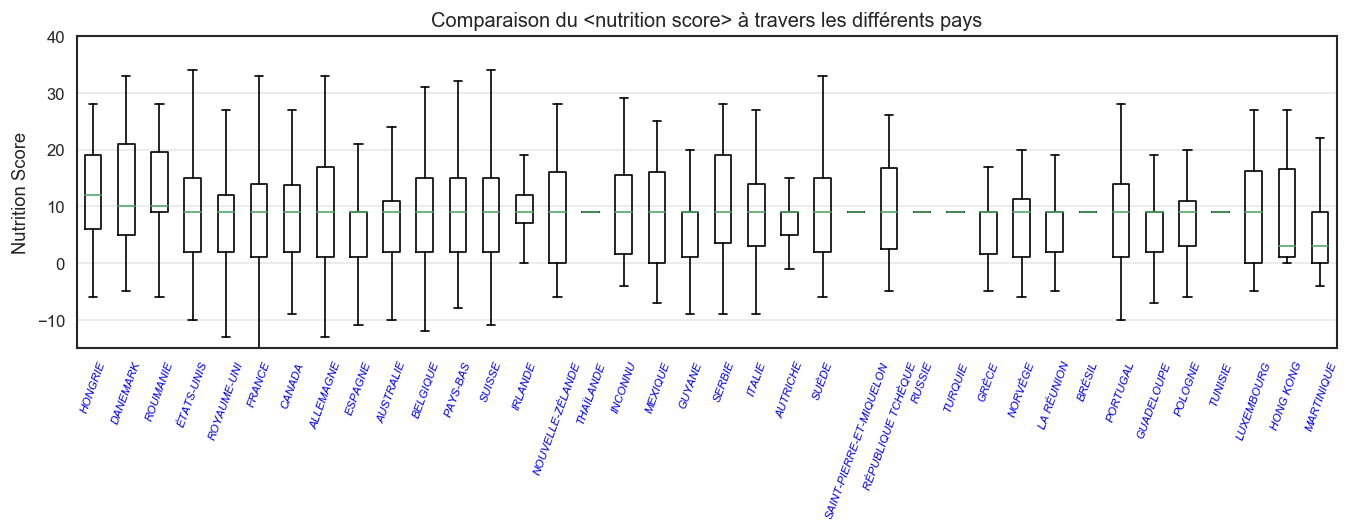

In [50]:
import statistics
countries = [country for (country, _scores) in sorted(scores.items(), key=lambda t: -statistics.median(t[1]))]    
plot_score_by(countries)

On remarque que les produits provenant de la Hongrie, Danemark, Roumanie présentent un  
score relativement élevé, mais il faut garder à l'esprit que la taille la donnée disponible n'est 
pas la même pour tous les pays

# Etape supplémentaire ?

Comme étape supplémentaire
- Exploiter la donnée Marque
- On peut construire des modalités pour la variable score (un partitionnement par intervalles contigus
de l’ensemble des valeurs possibles )  et créer un modèle de prédiction , qui prédit la modalité correspondant à un produit 
donnée au vu de ses caractéristiques nutritionnelles.
